# Section 4_Mini Batch SGD

### Objective
1. **데이터를 추출하는 여러가지 방법을 통해 DNN 모델의 성능을 개선시키는 법을 배워봅니다**



In [0]:
!pip install emnist
import tensorflow as tf
import random
import numpy as np
from emnist import extract_training_samples
from emnist import extract_test_samples

import matplotlib.pyplot as plt

### [Optional.  Tensorflow Graph Visualization ]

---

> _Jupyter에서 Tensorflow에서 구성되는 Graph를 시각적으로 보여주기 위한 helper 메소드입니다._<br>

In [0]:
from IPython.display import clear_output, Image, display, HTML
import numpy as np    

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))

    display(HTML(iframe))

## 문제 1. DataProvider 구현해보기


문제 설명 : 
numpy 을 이용해
random 으로 데이터를 지정한 크기만큼 추출하는 코드를 구현해 봅니다. 

- 한번 추출한 데이터는 다음번 데이터를 추출할 때 을 때 보존되지 않습니다. (비 복원 추출)
- 만약 지정한 batch size 보다 적은 데이터가 남아 있다면 데이터를 다시 섞고 처음부터 추출합니다.


#### 답안지 입력란
* 아래에 답을 서술하여 주세요
* `next_batch` 를 구현해 주세요. 
* `epoch_count`는 전체 데이터셋을 한번 반복하였을 때, 1씩 올라가게 됩니다.<br> next_batch를 반복해서 실행하면, epoch 별로 epoch_count가 1씩 올라가게됩니다.

In [0]:
import numpy.random as npr

In [0]:
class DataProvider(object):
    def __init__(self, x, y):
        ## fix me ##
        self.epoch_count = 0
        
        self.data = x
        self.label = y
        
        npr.seed(42)
        
        self.indices = self.generate_indices()
  
    def generate_indices(self):
        indices = list(range(len(self.data)))
        npr.shuffle(indices)
        
        return indices
    
    def next_batch(self, batch_size):
        idx = batch_size
        if len(self.indices) < batch_size:
            print("all data consumed, epoch + 1")
            self.epoch_count += 1
            self.indices = self.generate_indices()

        # slicing vs del(win)
    
        target_indices = self.indices[:batch_size]
        del self.indices[:batch_size]
        
        return self.data[target_indices], self.label[target_indices]

#### 정답 확인
* 정답을 입력한 후, 아래를 실행시키면 정답인지 확인합니다.

In [0]:
np.array([7,8,1])

array([7, 8, 1])

In [0]:
# 아래 코드를 수행해주세요. 
# 위에서 생성한 DataProvider instance 를 생성합니다 
random.seed(0)
xs = np.arange(0, 10)
ys = np.arange(0, 10)
dataprovider=DataProvider(xs, ys)

# 4번 비복원 추출합니다.
batch_xs1, batch_ys1 = dataprovider.next_batch(3)
batch_xs2, batch_ys2 = dataprovider.next_batch(3)
batch_xs3, batch_ys3 = dataprovider.next_batch(3)
batch_xs4, batch_ys4 = dataprovider.next_batch(3)

# 비복원 추출인지 아닌지를 판단합니다. 
batches_xs = np.concatenate([batch_xs1, batch_xs2, batch_xs3])
batches_ys = np.concatenate([batch_ys1, batch_ys2, batch_ys3])

if len(batches_xs) == 9 and len(batches_ys) == 9:
    pass;
else:
    raise ValueError("비복원 추출이 아닙니다. 다시 확인해주세요.")

# random하게 추출하는지 아닌지를 판단합니다.. 
# np.testing.assert_almost_equal(batch_xs1, np.array([7, 8, 1]),
#                                err_msg='next_batch 함수 설계가 잘못되었습니다. 아래를 참조해 다시 확인해주세요.')
# np.testing.assert_almost_equal(batch_ys1, np.array([7, 8, 1]),
#                                err_msg='next_batch 함수 설계가 잘못되었습니다. 아래를 참조해 다시 확인해주세요.')

# random epoch counter 가 제대로 작동하지 않습니다. 
if dataprovider.epoch_count == 1:
    print("정답입니다!!!!")
else:
    raise ValueError("epoch_counter 가 제대로 작동하지 않습니다. 다시 확인해주세요.")

all data consumed, epoch + 1
정답입니다!!!!


## 문제 2. Stochastic Batch 구현해보기


문제 설명 :
batch size 별로 Model의 accuracy , loss 을 비교해 봅니다.

- batch size 가 1, 30, 60, 120  일 때 test dataset 에 대한 loss 와 accuracy 을 구해서 비교해 봅니다. 
- 총 20 epoch 을 수행합니다. 


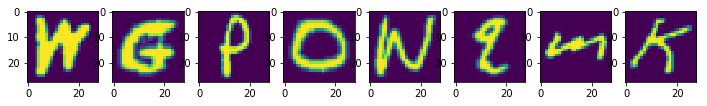

In [0]:
# 우선실행해 주세요!
# Data load and preprocessing 
train_images, train_labels = extract_training_samples('letters')
test_images, test_labels = extract_test_samples('letters')

# images normalization
train_images = train_images / 255.
test_images = test_images / 255.

# label normalization
train_labels = train_labels.copy() -1
test_labels = test_labels.copy() -1

fig = plt.figure(figsize=(12,3))
axes = fig.subplots(1,8)
for image, ax in zip(train_images, axes):
    ax.imshow(image)
plt.show()

# images flatten
train_images = np.reshape(train_images, [-1, 784])
test_images = np.reshape(test_images, [-1, 784])

n_classes = train_labels.max() + 1

In [0]:
# 아래 코드를 먼저 수행해주세요.
graph = tf.Graph()
with graph.as_default():
    # input placeholder
    xs = tf.placeholder(tf.float32, shape=[None, 28 * 28], name='xs')
    ys = tf.placeholder(tf.int64, shape=[None,], name='ys')
    lr = tf.placeholder_with_default(0.1,(),name='learning_rate')

    he_init = tf.initializers.he_normal()
    glorot_init = tf.initializers.glorot_normal()
    
    # Hidden Layer 
    h1 = tf.layers.Dense(64, activation=tf.nn.relu,
                         kernel_initializer=he_init,name='dense-1')(xs)
    h2 = tf.layers.Dense(128, activation=tf.nn.relu,
                         kernel_initializer=he_init,name='dense-2')(h1)
    h3 = tf.layers.Dense(256, activation=tf.nn.relu,
                         kernel_initializer=he_init,name='dense-3')(h2)

    # Logits Layer 
    logits = tf.layers.Dense(n_classes, kernel_initializer=glorot_init,
                             name='logits')(h3)

    # logits to prediction for multicalssification  
    pred = tf.nn.softmax(logits,name='prediction')

    # metric 
    with tf.variable_scope('metrics'):
        acc = tf.reduce_mean(
            tf.cast(tf.equal(tf.argmax(pred, axis=1), ys),tf.float32))
    acc = tf.identity(acc,name='accuracy')
        
    # cross-entropy-loss
    cee = tf.losses.sparse_softmax_cross_entropy(logits=logits, labels=ys)
    
    # optimizer
    train_op = (tf.train
                .GradientDescentOptimizer(lr)
                .minimize(cee))
    
show_graph(graph)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


#### 답안지 입력란
* 아래에 답을 서술하여 주세요
* 예제 1에서 작성한 코드와 위의 Graph를 이용해, 배치 사이즈 별로 어떻게 학습에서 차이가 나는지를 시각화 해주세요
* 총 20epoch을 진행해주세요

0 0 3.411894 0.03673077
0 100 3.0203915 0.19504808
0 200 2.618705 0.2885096
0 300 2.188109 0.40322116
0 400 1.8737819 0.4525
0 500 1.6951848 0.5050481
0 600 1.562894 0.5377404
0 700 1.5108899 0.5538942
0 800 1.3764861 0.59216344
0 900 1.4031329 0.57875
0 1000 1.2797338 0.6246154
0 1100 1.3056889 0.6158173
0 1200 1.3074228 0.6024038
0 1300 1.2133589 0.63802886
0 1400 1.1986604 0.6445673
0 1500 1.1594214 0.6562019
0 1600 1.1456475 0.6589423
0 1700 1.1357578 0.6639904
0 1800 1.1067735 0.67480767
0 1900 1.0720787 0.6808173
0 2000 1.0529332 0.68649036
0 2100 1.022449 0.6994712
0 2200 1.0533669 0.6897115
0 2300 0.9980573 0.7043269
0 2400 1.0032375 0.7008173
0 2500 0.9795491 0.70403844
0 2600 0.93806434 0.71552885
0 2700 0.9819212 0.69711536
0 2800 0.89905614 0.73033655
0 2900 0.9133038 0.72586536
0 3000 0.93240505 0.72177887
0 3100 0.869938 0.7446154
0 3200 0.92732346 0.7212019
0 3300 0.86014366 0.74572116
0 3400 0.89183694 0.7315385
0 3500 0.84857273 0.75076926
0 3600 0.8616607 0.74365383
0

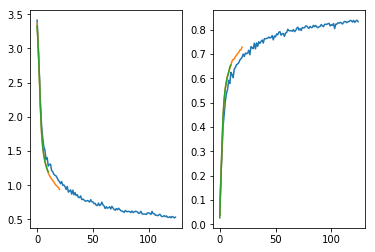

In [0]:
batch_sizes = [10, 60, 120]
# 정답을 서술해 주세요

fig, (loss_ax, acc_ax) = plt.subplots(1,2)
for batch_size in batch_sizes:
    dataprovider = DataProvider(train_images, train_labels)
    
    step = 0
    losses = []
    accs = []
    
    with tf.Session(graph=graph) as sess:
        sess.run(tf.global_variables_initializer())
        while dataprovider.epoch_count < 20:
#         for step in range(len(train_images)//batch_size):
            
            batch_xs, batch_ys = dataprovider.next_batch(batch_size)
            sess.run(train_op, feed_dict={xs: batch_xs, ys: batch_ys, lr: 0.01})
            
            if step % 100 == 0:
                cee_, acc_ = sess.run([cee, acc], feed_dict={xs: test_images, ys: test_labels, lr: 0.01})
                print(dataprovider.epoch_count, step, cee_, acc_)
                losses.append(cee_)
                accs.append(acc_)
            
        loss_ax.plot(range(len(losses)), losses)
        acc_ax.plot(range(len(accs)), accs)
        
plt.show()

### 정답 확인 : 

- batch size 을 1, 10, 60, 100 로 했을때 validation accuracy, loss graph 을 그려봅니다.

아래와 같은 모양이 나오면 정답입니다.


![Imgur](https://i.imgur.com/2CXUDqC.png)